## Behavioral Cloning

- In this project, I have train a CNN to predict the steering wheel angle based on the input from a camera mounted on the front of the car.
- The car is first driven around the track for a couple of laps to collect data
- The data is then cleaned and augmented.
- This data is used to train the CNN who's model architecture used is similar to the one used by NVIDIA

In [1]:
# Import all the packages that will be needed

import csv,cv2,copy,random
import numpy as np
from keras.models import Sequential
from keras.layers import Lambda, Flatten, Dense, Cropping2D, Convolution2D, Activation, MaxPooling2D, Dropout
from keras.layers.advanced_activations import ELU
from keras.regularizers import l2
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# After the car is manually driven around, the path to the images, and the steering angleis stored in driving_log.csv
# In this cell, list of images and steering wheel angles is created

lines, images, measurements = [], [], []
with open('driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

for line in lines:
    # source_path gives the path to the image
    # might have to be changed based on the location of the data
    
    # line[0] has the path to the center image
    source_path = line[0]
    image = cv2.imread(source_path)
    images.append(image)
    measurement = float(line[3])
    measurements.append(float(line[3]))

    # Augmenting the data to consider cases where the steering wheel has to be rotated in the other direction
    # This is done by mirroring the image
    mirror_image=cv2.flip(image,1)
    images.append(mirror_image)
    measurement = -1*float(line[3])
    measurements.append(measurement)

    # Empirically it was found that the network isn't given enough data to predict the steering angle when the \
    # car is close to the edge of the road. So the data from the right and left cameras is considered as well.
    # The steering wheel angle value is changed to teach the car that if its middle camera sees these images \
    # the car needs to turn (to avoid falling off) 
 
    source_path = line[1]
    image = cv2.imread(source_path)
    images.append(image)
    measurements.append(float(line[3]) + 0.3)

    source_path = line[2]
    image = cv2.imread(source_path)
    images.append(image)
    measurements.append(float(line[3]) - 0.3)

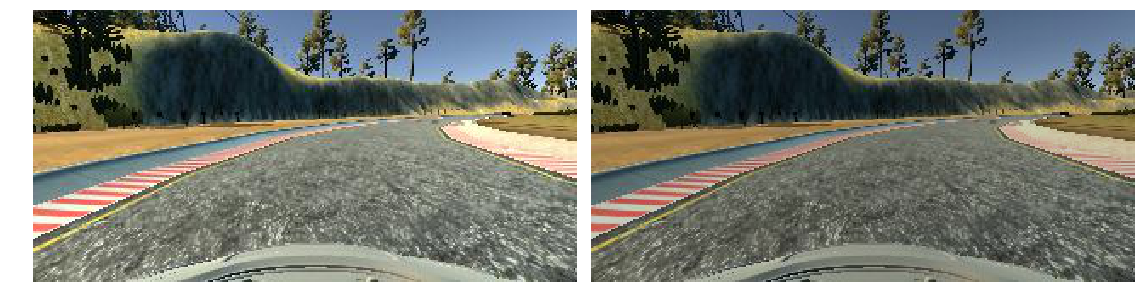

In [16]:
# The data augmentation described above trains the network well enough to let the car drive autonomously 
# But if the car is put on a new track which has more shadows, it does not perform as well
# To make the CNN robust to this, the data is further augmented. 
# The brightness of the entire image can be varied

# Brightness Augmentation
def brightness_augmentation(image):
    image = np.array(cv2.cvtColor(image,cv2.COLOR_BGR2HSV))
    image[:,:,2] = image[:,:,2]*0.8
    image[:,:,2][image[:,:,2]>255]  = 255
    image = np.array(image, dtype = np.uint8)
    image = cv2.cvtColor(image,cv2.COLOR_HSV2RGB)
    return image

image = images[0]
fig, axs = plt.subplots(1,2, figsize=(20, 5))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
axs[0].axis('off')
axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[1].axis('off')
axs[1].imshow(brightness_augmentation(image))

In [4]:
# Augmentevery 10th image by reducing brightness

for i in range(len(images)):
    # Augment every 20th image
    if i%10 == 0:
        new_image = brightness_augmentation(images[i])
        images.append(new_image)
        measurements.append(measurements[i])

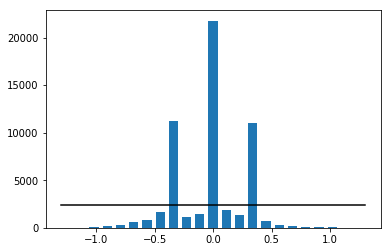

In [5]:
# print a histogram to see which steering angle ranges are most overrepresented
num_bins = 23
avg_samples_per_bin = len(measurements)/num_bins
hist, bins = np.histogram(measurements, num_bins)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(measurements), np.max(measurements)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
plt.show()

In [6]:
# It looks like some vaues of the steering wheel angle have significantly larger number of images than others
# This non-uniformity will result in the network predicting the over represented classes more frequently
# To avoid this, the number of examples from over represented classes must be reduced by deleting some examples

keep_probs = []
target = avg_samples_per_bin * .5
for i in range(num_bins):
    if hist[i] < target:
        keep_probs.append(1.)
    else:
        keep_probs.append(1./(hist[i]/target))

remove_list = []
for i in range(len(measurements)):
    for j in range(num_bins):
        if measurements[i] > bins[j] and measurements[i] <= bins[j+1]:
            # delete from X and y with probability 1 - keep_probs[j]
            if np.random.rand() > keep_probs[j]:
                remove_list.append(i)

images = np.delete(images, remove_list, axis=0)
measurements = np.delete(measurements, remove_list)

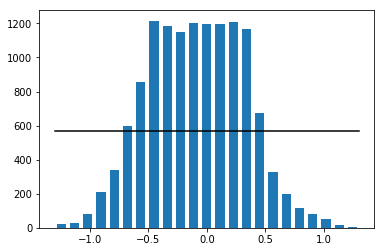

In [7]:
# Plot a histogram again to make sure the distribution is now uniform
# print a histogram to see which steering angle ranges are most overrepresented
num_bins = 23
avg_samples_per_bin = len(measurements)/num_bins
hist, bins = np.histogram(measurements, num_bins)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(measurements), np.max(measurements)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
plt.show()


In [8]:
# The training and validation split, and shuffling the data will be done later (keras libraries ensure this)

X_train = np.array(images)
Y_train = np.array(measurements)

In [11]:
# Define the model here

model = Sequential()
# Start by normalizing the data
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
# The road in from of the car should be the only thing influencing the steering wheel angle prediction
# Thus, the rest of the image must be cropped out
model.add(Cropping2D(cropping=((60,10),(0,0))))
model.add(Convolution2D(16, 3, 3, border_mode='same'))
model.add(Activation('tanh'))
model.add(MaxPooling2D((2, 2)))

model.add(Convolution2D(12, 3, 3, border_mode='same'))
model.add(Activation('tanh'))
model.add(MaxPooling2D((2, 2)))

model.add(Convolution2D(32, 3, 3, border_mode='same'))
model.add(Activation('tanh'))
model.add(MaxPooling2D((2, 2)))

model.add(Convolution2D(48, 3, 3, border_mode='same'))
model.add(Activation('tanh'))
model.add(MaxPooling2D((2, 2)))

model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('tanh'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(400))
model.add(Activation('tanh'))

model.add(Dense(200))
model.add(Activation('tanh'))

model.add(Dense(32))
model.add(Activation('tanh'))

# The final layer must have a single node since this is a regression problem
model.add(Dense(1))

In [12]:
# Compiling, Fitting (Tuning the weights),and storing the weights 
model.compile(loss='mse',optimizer='adam')
model.fit(X_train,Y_train,validation_split=0.2,shuffle=True, nb_epoch=10)
model.save('model.h5')

Train on 10508 samples, validate on 2627 samples
Epoch 1/10
10508/10508 [==============================] - 301s - loss: 0.0663 - val_loss: 0.0627
Epoch 2/10
10508/10508 [==============================] - 266s - loss: 0.0394 - val_loss: 0.0545
Epoch 3/10
10508/10508 [==============================] - 194s - loss: 0.0363 - val_loss: 0.0572
Epoch 4/10
10508/10508 [==============================] - 189s - loss: 0.0334 - val_loss: 0.0552
Epoch 5/10
10508/10508 [==============================] - 205s - loss: 0.0312 - val_loss: 0.0575
Epoch 6/10
10508/10508 [==============================] - 194s - loss: 0.0270 - val_loss: 0.0621
Epoch 7/10
10508/10508 [==============================] - 226s - loss: 0.0230 - val_loss: 0.0613
Epoch 8/10
10508/10508 [==============================] - 217s - loss: 0.0201 - val_loss: 0.0579
Epoch 9/10
10508/10508 [==============================] - 203s - loss: 0.0176 - val_loss: 0.0623
Epoch 10/10
10508/10508 [==============================] - 206s - loss: 0.0142

### Conclusions

- Data augmentation is the key to developing a robust CNN. Its better to start off by augmenting the data if the network is not performing as needed, rather than just making the network deeper

- The number of examples/images for each label needs to be as close to uniform as possible. If not, the network tends to predict the over represented class very frequently